In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [130]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
import graphviz

In [131]:
iris = load_iris()
x = iris.data[:, 2:] #petal width and petal length only 
y = iris.target

In [132]:
treeclf = DecisionTreeClassifier()
treeclf.fit(x, y)

DecisionTreeClassifier()

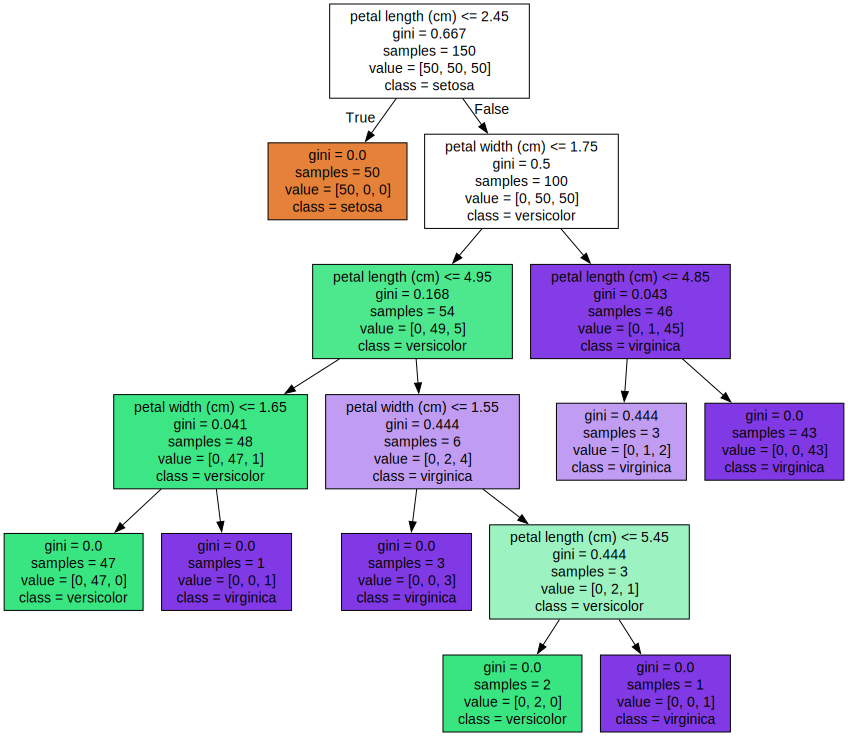

In [133]:
graphtree = export_graphviz(treeclf, 
                out_file= None,
               feature_names = iris.feature_names[2:],
               class_names = iris.target_names,
                            filled = True
               )
graph = graphviz.Source(graphtree, format="png") 
graph

In [134]:
treeclf.predict_proba([[5,1.5]])

array([[0., 0., 1.]])

In [135]:
treeclf.predict([[5,1.5]])

array([2])

In [136]:
treereg = DecisionTreeRegressor(max_depth = 2)
treereg.fit(x, y)

DecisionTreeRegressor(max_depth=2)

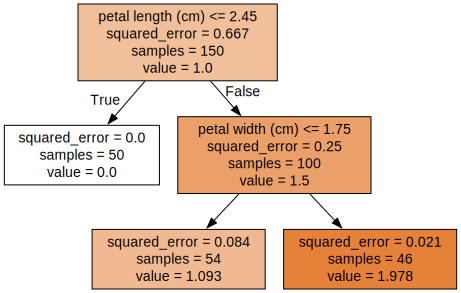

In [137]:
graphtree = export_graphviz(treereg, 
                out_file= None,
               feature_names = iris.feature_names[2:],
               class_names = iris.target_names,
                            filled = True
               )
graph = graphviz.Source(graphtree, format="png") 
graph

# Exercises 

7. Train and fine-tune a Decision Tree for the moons dataset.

    a. Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).


In [138]:
from sklearn.datasets import make_moons 

x, y = make_moons(n_samples = 10000, noise = 0.4)

  b. Split it into a training set and a test set using train_test_split()

In [139]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

c. Use grid search with cross-validation (with the help of the GridSearchCV
class) to find good hyperparameter values for a DecisionTreeClassifier. 
Hint: try various values for max_leaf_nodes.


In [140]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"max_leaf_nodes" : [10, 100, 1000, 10000, 100000]}, 
    {"max_depth": [5, 10, 15, 20, 25]}
]

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv = 5)
grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_leaf_nodes': [10, 100, 1000, 10000, 100000]},
                         {'max_depth': [5, 10, 15, 20, 25]}])

In [141]:
grid_search.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=10)

In [142]:
grid_search.best_params_

{'max_leaf_nodes': 10}

In [143]:
clf = DecisionTreeClassifier(max_leaf_nodes = 10)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(max_leaf_nodes=10)

d. Train it on the full training set using these hyperparameters, and measure
your model’s performance on the test set. You should get roughly 85% to 87%
accuracy

In [144]:
from sklearn.metrics import accuracy_score

prediction = clf.predict(xtest)
score = accuracy_score(ytest, prediction)
print("The accuracy is :", score)

The accuracy is : 0.8415


8. Grow a forest.

    a. Continuing the previous exercise, generate 1,000 subsets of the training set,
    each containing 100 instances selected randomly. Hint: you can use Scikit Learn’s ShuffleSplit class for this.

In [145]:
from sklearn.model_selection import ShuffleSplit
mini_sets = []
splitobj = ShuffleSplit(n_splits = 1000, train_size = 100)
for mini_train_index, mini_test_index in splitobj.split(xtrain):
    x_mini_train = xtrain[mini_train_index]
    y_mini_train = ytrain[mini_train_index]
    mini_sets.append((x_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values
found above. Evaluate these 1,000 Decision Trees on the test set. Since they
were trained on smaller sets, these Decision Trees will likely perform worse
than the first Decision Tree, achieving only about 80% accuracy.

In [146]:
from sklearn.base import clone

forest = [clone(grid_search.best_estimator_) for _ in range(1000)]

accuracy_scores = []

for tree, (x_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(x_mini_train, y_mini_train)
    
    y_pred = tree.predict(xtest)
    accuracy_scores.append(accuracy_score(ytest, y_pred))

np.mean(accuracy_scores)

0.799269

In [147]:
print("The average accuracy after training decision tree on subset is : ",statistics.mean(accuracy))

The average accuracy after training decision tree on subset is :  0.8132733333333333


c. Now comes the magic. For each test set instance, generate the predictions of
the 1,000 Decision Trees, and keep only the most frequent prediction (you can
use SciPy’s mode() function for this). This gives you majority-vote predictions
over the test set.

In [148]:
y_pred = np.empty([1000, len(xtest)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    y_pred[tree_index] = tree.predict(xtest)

In [149]:
y_pred_majority_votes = mode(y_pred)
y_pred_majority_votes.mode

array([0, 1, 0, ..., 1, 1, 1])

d. Evaluate these predictions on the test set: you should obtain a slightly higher
accuracy than your first model (about 0.5 to 1.5% higher). Congratulations,
you have trained a Random Forest classifier!

In [150]:
accuracy_score(ytest, y_pred_majority_votes.mode)

0.844